# INFO-F-422 Project 23-24 : Zindi: - Urban Air Pollution Challenge - 

## Description of the Project

### Problem

### Data

### scoring metric

## Tasks

### Packages

In [2]:
library(dplyr)
library(randomForest)
library(ggplot2)
library(RSNNS)
library(e1071)
library(xgboost)
library(keras)
library(repr)
library(caret)
library(lubridate)
library(VIM)
library(lightgbm)

options(repr.matrix.max.cols=500, repr.matrix.max.rows=200)
#set.seed(42)

### 1. Pipeline
This section will contain a few functions that can be called to modify, complete or create new features.`

These Functions can then after be called easilly to try different combinations.

#### Data importation & Feature selection

2 simple functions that helps getting a clean data easilly for each model

In [3]:
get_train_data <- function() {
    train_df <- read.csv("Data/Train.csv")
    train_df <- train_df %>% 
        select(-"target_min", -"target_max",-"target_variance",-"target_count")
    return(train_df)
}

In [4]:
get_test_data <- function() {
    train_df <- read.csv("Data/Test.csv")
    return(train_df)
}

#### Missing value imputation

Different methods that can be applied to the data in order avoid keeping empty data in the datasets.
1. This method simply deletes all columns containing nan's and keeps only the ones that are complete. This method is quite drastic and reduces a lot our dataset.
2. The second method will tranform all the nan's in the data by the mean of that column. This allows to keep all the original data.
3. The third method will tranform all the nan's in the data by the median of that column. This allows to keep all the original data.
4. The fourth method will tranform all the nan's in the data by the median of that column but grouped for each station. alowing us to keep all the data and also laverage the information of the median of the area.

In [5]:
# Drop na's
drop_na <- function(data) {
    data_clean <- data[, colSums(is.na(data)) == 0]
    return(data_clean)
}

In [6]:
# Replace na's by mean
na_to_mean <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))
    return(data_clean)
}

In [7]:
# Replace na's by median
na_to_median <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), median(., na.rm = TRUE), .)))
    return(data_clean)
}

In [8]:
# Replace NA's by the median by Place_ID
na_to_median_by_location <- function(data) {
    # Step 1: Replace NA's within each Place_ID group
    data_clean <- data %>%
        group_by(Place_ID) %>%
        mutate(across(where(is.numeric), ~ifelse(is.na(.), median(., na.rm = TRUE), .))) %>%
        ungroup()

    # Step 2: Calculate global medians for each numeric column
    global_medians <- data %>%
        summarize(across(where(is.numeric), median, na.rm = TRUE)) %>%
        unlist()
    
    # Step 3: Replace remaining NA's with global medians
    data_clean <- data_clean %>%
        mutate(across(where(is.numeric), ~ifelse(is.na(.), global_medians[cur_column()], .)))

    return(data_clean)
}


#### Normalization

That function will normalize the whole dataset pet column. (the function scale will also be used later)

In [9]:
#Function that will normalize all the columns
normalize <- function(x) {
  (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
}

#### Feature engineering

In [10]:
# Add columns for day, mounth, year, day of the week and if it is weekend or not.
add_time <- function(data) {
    data <- data %>%
        mutate(day = day(Date),
               month = month(Date),
               day_of_week = wday(Date),
               s_weekend = as.integer(wday(Date) %in% c(6, 7)))
    data <- data %>%
        group_by(Place_ID) %>%
        mutate(placeID_freq = n()) %>%
        ungroup()

    return(data)
}

In [11]:
# Function to add lag, lead of all the columns enabeling it to see what was before and after
add_lag_lead <- function(data, days) {
    # Features: Excluding specific columns from the dataset
    features <- setdiff(names(data), c("Date", "target_count", "target_min", "Place_ID X Date", "target_variance", "target_max", "Place_ID.X.Date", "target"))
    
    numeric_features <- sapply(data, is.numeric)
    features <- names(numeric_features[numeric_features == TRUE])
    features <- setdiff(features, c("target", "Place_ID.X.Date", "Date"))
    
    # Wrap operations in a group_by() without arranging
    data <- data %>%
        group_by(Place_ID) %>%
        mutate(across(all_of(features), ~lag(.x, 1), .names = "prev_{.col}_1"),
               across(all_of(features), ~lead(.x, 1), .names = "next_{.col}_1")) %>%
        ungroup()  # Return to regular data frame operation without groups
    
    # Now create the difference features
    for (i in 1:days) {
        # Creating difference features for lag
        data <- data %>%
            group_by(Place_ID) %>%
            mutate(across(all_of(features), ~. - lag(., i), .names = paste0("prev_{.col}_", i+1))) %>%
            ungroup()
        
        # Creating difference features for lead
        data <- data %>%
            group_by(Place_ID) %>%
            mutate(across(all_of(features), ~. - lead(., i), .names = paste0("next_{.col}_", i+1))) %>%
            ungroup()
    }
    
    # Replace NA values in numeric columns with 0
    numeric_columns <- sapply(data, is.numeric)
    data[numeric_columns] <- lapply(data[numeric_columns], function(x) replace(x, is.na(x), 0))
    
    return(data)
}


#### Divide train / validation set

In [12]:
# randomise stations in train and val by grouping the Place_ID's
# This allows to not overfit with the test data that doesn't contain similar Place_ID's as the training data.
get_train_val_by_station <- function(data,rep) {
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    num_train <- round(length(shuffled_place_ids) * rep)
    train_ids <- shuffled_place_ids[1:num_train]
    val_ids <- shuffled_place_ids[(num_train + 1):length(shuffled_place_ids)]
    train <- data[data$Place_ID %in% train_ids, ] %>% 
      select(-"Place_ID")
    val <- data[data$Place_ID %in% val_ids, ] %>% 
      select(-"Place_ID")
    return(list(train = train, val = val))
}

# Unfortunatly this method when applied seemed to give worse results compared to the normal random division.
# This is why in the next steps only the normal random division will be used.

In [13]:
# Random attiribution of each line to train or val. this will give us a bigger difference between the val score and the test 
# score beceause no station will be in commun.
get_train_val <- function(data, rep) {
    shuffled_indices <- sample(nrow(data))
    num_train <- round(nrow(data) * rep)
    train_indices <- shuffled_indices[1:num_train]
    val_indices <- shuffled_indices[(num_train + 1):nrow(data)]
    train <- data[train_indices, ] %>% 
      select(-"Place_ID")
    val <- data[val_indices, ] %>% 
      select(-"Place_ID")
    return(list(train = train, val = val))
}

#### Configuration grid example
This allows to decide for each test which missing value imputation, normalization, feature engeneering and train_val repartition to use

In [98]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
# data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID X Date","Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

#### Plot repartition of the data

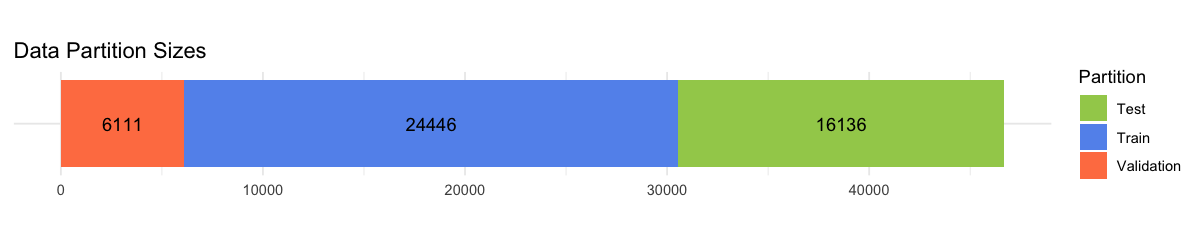

In [99]:
partition_sizes <- data.frame(
  Partition = c("Train", "Validation", "Test"),
  Size = c(nrow(data_train_val$train), nrow(data_train_val$val), nrow(test_data))
)

# Plot the partition sizes
options(repr.plot.width = 10, repr.plot.height = 2)
ggplot(partition_sizes, aes(x = "", y = Size, fill = Partition)) +
  geom_bar(stat = "identity", width = 1) +
  coord_flip() +
  geom_text(aes(label = Size), position = position_stack(vjust = 0.5)) +
  theme_minimal() +
  labs(title = "Data Partition Sizes", x = NULL, y = NULL) +
  scale_fill_manual(values = c("Train" = "cornflowerblue", "Validation" = "coral", "Test" = "darkolivegreen3")) +
  theme(
    axis.ticks = element_blank(), 
    axis.text.y = element_blank(),
    aspect.ratio = 1/10 # Adjust the aspect ratio to make the plot shorter
  )

### 2. Model selection

#### Data preparation for all models

###### Input configuration

In [16]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
#data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

In [17]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target

val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target

# Normalize the features (if necessary)
train_x_norm <- scale(train_x)
val_x_norm <- scale(val_x)

#### Neural Network

In [18]:
create_nn_model <- function(input_shape) {
  nn_model <- keras_model_sequential() %>%
    layer_dense(units = 128, activation = 'relu', input_shape = input_shape) %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dense(units = 1)
  
  nn_model %>% compile(
    loss = 'mse',  # Mean Squared Error for regression
    optimizer = 'adam',  # Adaptive moment estimation
    metrics = c('mean_absolute_error')
  )
  
  return(nn_model)
}

# Create the model
input_shape <- ncol(train_x)
model <- create_nn_model(input_shape)

# Train the model
history <- model %>% fit(
  train_x_norm, train_y,
  epochs = 1000,
  batch_size = 32,
  validation_split = 0.2
)

# Make predictions on the validation data
predictions <- model %>% predict(val_x_norm)
rmse <- sqrt(mean((predictions - val_y)^2))
score_nn = rmse
print(paste("RMSE: ", rmse))

[1] "RMSE:  32.3823375388647"


#### RSNNS

In [19]:
control <- trainControl(method = "none")
RSNNS_model <- train(train_x_norm, train_y, method = "mlp", trControl = control)

In [20]:
predictions <- predict(RSNNS_model, val_x_norm)
rmse <- sqrt(mean((predictions - val_y)^2))
score_rsnns = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 48.453524405078"


#### SVM

In [21]:
svm_model <- svm(target ~ ., data = data_train_val$train)

In [22]:
predictions <- predict(svm_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_svm = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 30.0327501465375"


#### Randomforest

In [23]:
rf_model <- randomForest(target ~ ., data = data_train_val$train)

In [24]:
predictions <- predict(rf_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_rf = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 29.8543996344159"


#### Comparison

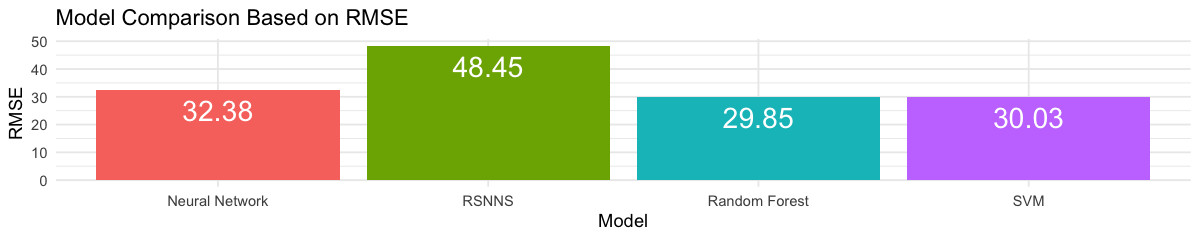

In [62]:
# Create a dataframe with RMSE values
rmse_df <- data.frame(
  Model = c("Neural Network", "RSNNS", "SVM", "Random Forest"),
  RMSE = c(score_nn, score_rsnns, score_svm, score_rf))

# Plot RMSE values
ggplot(rmse_df, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(RMSE, 2)), vjust = 1.5, color = "white", size = 6) +
  theme_minimal() +
  ggtitle("Model Comparison Based on RMSE")+
  theme(legend.position = "none")

### 3. Other model implementation

#### XGBoost

###### Input configuration

In [26]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
#data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

In [27]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target

val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target

# Normalize the features (if necessary)
#train_x_norm <- scale(train_x)
#val_x_norm <- scale(val_x)

###### Implementation

In [28]:
train_x_matrix <- as.matrix(train_x)
train_y_vector <- as.numeric(train_y)
dtrain <- xgb.DMatrix(data = train_x, label = train_y)

xgb_model <- xgb.train( data = dtrain, nrounds = 50)

In [29]:
dval <- xgb.DMatrix(data = val_x)
predictions <- predict(xgb_model, dval)
rmse <- sqrt(mean((predictions - val_y)^2))
score_xgb = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 33.2578646728697"


#### LGB model

###### Input configuration

In [86]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_train_val <- get_train_val(train_data ,0.8)

In [100]:
train_x <- data_train_val$train %>% select(-c(target)) %>% as.matrix()
train_y <- data_train_val$train$target

val_x <- data_train_val$val %>% select(-target) %>% as.matrix()
val_y <- data_train_val$val$target

# Normalize the features (if necessary)
#train_x_norm <- scale(train_x)
#val_x_norm <- scale(val_x)

###### Implementation basic model

In [101]:
dtrain <- lgb.Dataset(data = train_x, label = train_y)#, free_raw_data = FALSE)
dtest <- lgb.Dataset(data = val_x, label = val_y)#, free_raw_data = FALSE)

# Parameters setup for LightGBM
params <- list(
    objective = "regression",
    metric = "rmse")

# Train the LightGBM model with early stopping
lgb_model <- lgb.train(
  params = params,
  data = dtrain)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.398075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435208
[LightGBM] [Info] Number of data points in the train set: 24446, number of used features: 1797
[LightGBM] [Info] Start training from score 61.120825


In [102]:
predictions <- predict(lgb_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_lgb_basic = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 25.9192455060904"


###### Implementation finetuned model

In [103]:
dtrain <- lgb.Dataset(data = train_x, label = train_y, free_raw_data = FALSE)
dtest <- lgb.Dataset(data = val_x, label = val_y, free_raw_data = FALSE)

# Parameters setup for LightGBM
params <- list(
    objective = "regression",
    metric = "rmse",
    force_col_wise = TRUE,
    num_leaves = 50,
    max_depth = -1,
    min_data_in_bin = 50
)

# Train the LightGBM model with early stopping
lgb_model <- lgb.train(
  params = params,
  data = dtrain,
  nrounds = 200,  # Use nrounds instead of num_boost_round
  early_stopping_rounds = 10,
  valids = list(test = dtest),  # Use valids instead of valid_sets
  verbose = 1500  # Use verbose instead of verbose_eval
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.798559
[LightGBM] [Info] Total Bins 410015
[LightGBM] [Info] Number of data points in the train set: 24446, number of used features: 1797
[LightGBM] [Info] Start training from score 61.120825
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[1]:  test's rmse:44.4292 
Will train until there is no improvement in 10 rounds.
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[2]:  test's rmse:42.5805 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[3]:  test's rmse:40.9783 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[4]:  test's rmse:39.5323 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[5]:  test's rmse:38.2508 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[6]:  test's rmse:37.163 
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[7]:  test's rmse:36.1741 
[LightGBM] [Debug] Trained a tre

In [104]:
predictions <- predict(lgb_model, val_x)
rmse <- sqrt(mean((predictions - val_y)^2))
score_lgb_basic = rmse
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 24.5889087447468"


#### Comparison

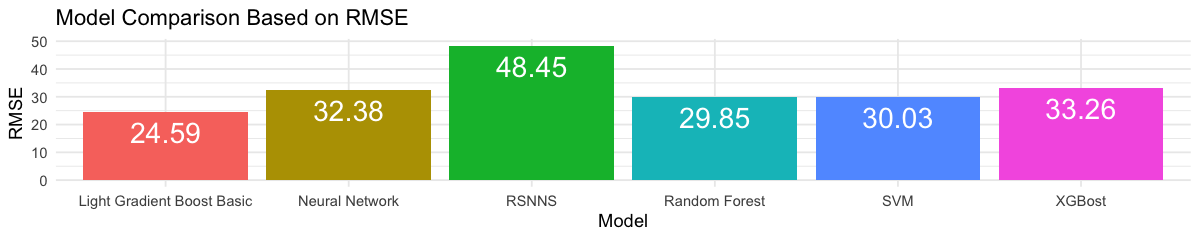

In [105]:
# Create a dataframe with RMSE values
rmse_df <- data.frame(
  Model = c("Neural Network", "RSNNS", "SVM", "Random Forest", "XGBost", "Light Gradient Boost Basic"),
  RMSE = c(score_nn, score_rsnns, score_svm, score_rf, score_xgb, score_lgb_basic))

# Plot RMSE values
ggplot(rmse_df, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(RMSE, 2)), vjust = 1.5, color = "white", size = 6) +
  theme_minimal() +
  ggtitle("Model Comparison Based on RMSE")+
  theme(legend.position = "none")

#### Training model on the complete dataset

In [32]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID.X.Date","Place_ID"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]

In [33]:
train_x <- train_data %>% select(-c(target)) %>% as.matrix()
train_y <- train_data$target

In [34]:
dtrain <- lgb.Dataset(data = train_x, label = train_y, free_raw_data = FALSE)

# Parameters setup for LightGBM
params <- list(
    objective = "regression",
    metric = "rmse",
    force_col_wise = TRUE,
    num_leaves = 50,
    max_depth = -1,
    min_data_in_bin = 50
)

# Train the LightGBM model with early stopping
lgb_model <- lgb.train(
  params = params,
  data = dtrain)

[LightGBM] [Info] Total Bins 414161
[LightGBM] [Info] Number of data points in the train set: 30557, number of used features: 1797
[LightGBM] [Info] Start training from score 61.148045


### 4. Zindi completition 

In [36]:
test_data <- as.data.frame(test_data)
test_x <- as.matrix(select(test_data, -target))
predictions <- predict(lgb_model, test_x)
# predictions <- round(predictions) # Option to round the predictions
predictions_df <- data.frame(
  "Place_ID X Date" = tail(data,length(predictions))$Place_ID.X.Date,
  target = predictions
)

if (all(dim(predictions_df) == c(16136, 2))) {
    write.csv(predictions_df, "predictions.csv", row.names = FALSE)
    print("File Saved")
} else {
  print("Output format is not correct")
}

[1] "File Saved"


The results obtained using the final LGB model were uploaded on Zindi and gave us a RMSD of 31.62746413. a quite good result placing us in the position 75 of the competition.

### 5. ranking of the features

## Competition results

## Further implementations to increase the score